In [1]:
# import important libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Sequential,backend, callbacks, optimizers ,metrics, Model, losses
from tensorflow.keras.layers import Dense, Activation, Input, BatchNormalization
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from skmultilearn.model_selection import IterativeStratification

2024-05-20 19:32:52.848925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 19:32:52.849030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 19:32:52.976969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# importing data
train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_target_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')

In [3]:
train_features.sample(5)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
18029,id_c19435749,trt_cp,24,D2,0.5947,-0.5885,-0.4679,-0.1869,0.2049,0.8321,...,0.5759,0.1261,0.5654,0.4161,-1.5890,-0.1461,0.7328,0.0347,0.3470,-0.7548
18759,id_c97cbb590,trt_cp,48,D2,1.0200,0.0414,-0.0010,-0.0634,-0.2308,1.6140,...,0.0769,-0.8892,-0.1525,-1.1070,-0.0811,-1.1410,0.4018,-0.3446,-2.4990,0.3081
19135,id_cd7494101,trt_cp,24,D1,1.9250,1.6250,1.1120,0.0432,-0.7434,1.9320,...,-0.3906,0.4949,0.3981,-0.0375,1.3920,-0.2101,0.6233,1.0080,-0.3919,0.7456
18488,id_c67759922,trt_cp,48,D1,-0.4664,0.2670,-0.2750,0.2155,-0.2680,-0.2538,...,1.0280,0.6812,1.0680,-0.5873,0.1980,0.2783,0.1109,0.5205,-0.1297,-0.6580
10347,id_6f8181ead,ctl_vehicle,72,D2,0.4791,2.0980,-0.1237,-0.7642,1.2360,-1.4580,...,-0.0746,0.1371,-0.0715,1.2020,-0.0224,0.0835,0.1032,0.9418,-0.3477,1.0600


In [4]:
# separating cell features and gene features
gene_features = []
cell_features = []
for i in train_features.columns:
    if i.startswith('g-'):
        gene_features.append(i)
    if i.startswith('c-'):
        cell_features.append(i)

print('the length of gene features', len(gene_features))
print('the lenght of cell features', len(cell_features))

train_merge = pd.merge(train_features, train_target_scored, on = 'sig_id', how = 'left')
print('the length of all inputs and target dataset', train_merge.shape)

the length of gene features 772
the lenght of cell features 100
the length of all inputs and target dataset (23814, 1082)


In [5]:
from sklearn.preprocessing import LabelEncoder
x = train_merge.copy()
le = LabelEncoder()
x['cp_type'] = le.fit_transform(x['cp_type'])
x['cp_time'] = le.fit_transform(x['cp_time'])
x['cp_dose'] = le.fit_transform(x['cp_dose'])

test_features['cp_type'] = le.fit_transform(test_features['cp_type'])
test_features['cp_time'] = le.fit_transform(test_features['cp_time'])
test_features['cp_dose'] = le.fit_transform(test_features['cp_dose'])

In [6]:
target_cols = [col for col in train_target_scored.columns if col not in ['sig_id']]
y = x[target_cols]

In [7]:
x.shape, test_features.shape, y.shape

((23814, 1082), (3982, 876), (23814, 206))

In [8]:
# Autoencoder gene features
# encoder part
tf.random.set_seed(42)
inputs = Input(shape = (772,))
encoder_1 = Dense(512, activation = 'relu')(inputs)
batch_norm = BatchNormalization()(encoder_1)
encoder_2 = Dense(420, activation = 'relu')(batch_norm)

# decoder part
decoder_1 = Dense(420, activation = 'relu')(encoder_2)
batch_norm = BatchNormalization()(decoder_1)
decoder_2 = Dense(512, activation = 'relu')(batch_norm)
batch_norm = BatchNormalization()(decoder_2)
decoder_3 = Dense(772)(encoder_2)

model = tf.keras.Model(inputs = inputs, outputs = decoder_3)

model.compile(optimizer = optimizers.Adam(), loss = 'mse')

model.fit(x[gene_features], x[gene_features], batch_size = 512, epochs = 300, verbose = 1)

Epoch 1/300
34/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2755

I0000 00:00:1716233596.061201      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716233596.078925      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.1866
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6834
Epoch 3/300


W0000 00:00:1716233597.236429      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5957
Epoch 4/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5346
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4834
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4372
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3939
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3542
Epoch 9/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3204
Epoch 10/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2928
Epoch 11/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2716
Epoch 12/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2552
Epoch 13/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2421
Epoch 14/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2321
Epoch 15/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2246
Epoch 16/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2186
Epoch 17/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2155
Epoch 18/300
4

In [9]:
encoder = tf.keras.Model(inputs = inputs, outputs = encoder_2)
encoder.save('encoders_gene_features.h5')

In [10]:
# Autoencoder cell features
# encoder part
tf.random.set_seed(42)
inputs = Input(shape = (100,))
encoder_1 = Dense(90, activation = 'relu')(inputs)
batch_norm = BatchNormalization()(encoder_1)
encoder_2 = Dense(75, activation = 'relu')(batch_norm)

# decoder part
decoder_1 = Dense(75, activation = 'relu')(encoder_2)
batch_norm = BatchNormalization()(decoder_1)
decoder_2 = Dense(90, activation = 'relu')(batch_norm)
batch_norm = BatchNormalization()(decoder_2)
decoder_3 = Dense(100)(encoder_2)

model = tf.keras.Model(inputs = inputs, outputs = decoder_3)

model.compile(optimizer = 'adam', loss = 'mse')

with tf.device('/GPU:0'):
    model.fit(x[cell_features], x[cell_features],batch_size = 512, epochs = 300, verbose = 1)

Epoch 1/300
27/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1276 

W0000 00:00:1716233655.919700      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2.5610
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6120
Epoch 3/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5559
Epoch 4/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5227
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4980
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4769
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4597
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4443
Epoch 9/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4310
Epoch 10/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4189
Epoch 11/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4080
Epoch 12/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3982
Epoch 13/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3888
Epoch 14/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3794
Epoch 15/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3707
Epoch 16/300
47

In [11]:
encoder = tf.keras.Model(inputs = inputs, outputs = encoder_2)
encoder.save('encoders_cell_features.h5')

In [12]:
model.evaluate(x[cell_features], x[cell_features])

745/745 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1998


0.2036578506231308

In [13]:
from tensorflow.keras.models import load_model

encoder = load_model('/kaggle/working/encoders_gene_features.h5')
train_gene_features = encoder.predict(x[gene_features])
test_gene_features = encoder.predict(test_features[gene_features])

encoder = load_model('/kaggle/working/encoders_cell_features.h5')
train_cell_features = encoder.predict(x[cell_features])
test_cell_features = encoder.predict(test_features[cell_features])

745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
745/745 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [14]:
x_1_train = np.hstack((x['cp_type'].values.reshape(-1,1), x['cp_time'].values.reshape(-1, 1),
                       x['cp_dose'].values.reshape(-1, 1),
                       train_gene_features, train_cell_features))
x_1_test = np.hstack((test_features['cp_type'].values.reshape(-1,1),
                      test_features['cp_time'].values.reshape(-1, 1),
                      test_features['cp_dose'].values.reshape(-1, 1),
                      test_gene_features, test_cell_features))
x_1_train.shape, x_1_test.shape

((23814, 498), (3982, 498))

In [15]:
# create a Neural Network Model

num_of_labels = y.shape[1]
num_test_samples = test_features.shape[0]
y = y.to_numpy()

# predicting threshold  (p_min = 0.0005 p_max = 0.9995)

def logloss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # convert y_true to float32
    y_pred = tf.clip_by_value(y_pred,0.0005, 0.9995)
    return -backend.mean(y_true * backend.log(y_pred) + (1 - y_true) * backend.log(1 - y_pred))

n_seeds = 3
n_folds = 7
hists = []
oof = tf.constant(0.0)
y_pred = np.zeros((num_test_samples, num_of_labels))
bias = tf.keras.initializers.constant(np.log(y.mean(axis = 0)))

# training loop
seeds = [34, 9, 18]
for seed in seeds:
    fold = 0
    stratifier = IterativeStratification(n_splits=7, order=1)
    
    for train_idx, test_idx in stratifier.split(x_1_train, y):
        X_train = x_1_train[train_idx]
        X_test = x_1_train[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        model = Sequential([
            layers.Dropout(0.3),
            Dense(2048, activation = 'relu'),
            BatchNormalization(),
            layers.Dropout(0.5),
            Dense(1024, activation = 'relu'),
            BatchNormalization(),
            layers.Dropout(0.5),
            Dense(512),
            BatchNormalization(),
            layers.Dropout(0.3),
            Dense(num_of_labels, activation = 'sigmoid', bias_initializer = bias)
        ])
        model.compile(optimizer = optimizers.Adam(learning_rate = 1e-5),
                     loss = losses.BinaryCrossentropy(label_smoothing = 0.001),
                     metrics = ['binary_crossentropy', logloss])
        early_stopping = callbacks.EarlyStopping(monitor = 'val_logloss', patience = 5, mode = 'min')
        def scheduler(epoch, lr):
            if epoch % 16 < 9:
                lr += np.exp(-int(epoch / 16)) * (0.5 * 1e-2) / 16
            else:
                lr -= np.exp(-int(epoch / 16)) * (0.5 * 1e-2) / 16
            return lr
        lr_scheduler = callbacks.LearningRateScheduler(scheduler)

        history = model.fit(X_train, y_train, batch_size = 128, epochs = 192, verbose = 1,
                           validation_data = (X_test, y_test), callbacks = [lr_scheduler, early_stopping])
        
        # run the model without callbacks = [lr_scheduler]
        model.compile(optimizer = optimizers.Adam(learning_rate = 1e-5),
                     loss = losses.BinaryCrossentropy(label_smoothing = 0.001),
                     metrics = ['binary_crossentropy', logloss])
        
        
        model.fit(X_train, y_train, batch_size = 128, epochs = 192, verbose = 1,
                           validation_data = (X_test, y_test), callbacks = [early_stopping])
        
        hists.append(history)  
        
        model.save(f'AutoEncoded_seed_{seed}_fold_{fold}.h5')
        
        y_valid = model.predict(X_test)
        oof += logloss(tf.constant(y_test, dtype = tf.float32),
                      tf.constant(y_valid, dtype = tf.float32)) / (n_folds * n_seeds)
        
        y_pred += model.predict(x_1_test) / (n_folds * n_seeds)
        
        fold += 1

Epoch 1/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0264 - logloss: 0.0263 - loss: 0.0296

W0000 00:00:1716233714.757237      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0271

W0000 00:00:1716233722.651438      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716233723.449374      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0271 - val_binary_crossentropy: 0.0183 - val_logloss: 0.0182 - val_loss: 0.0215 - learning_rate: 3.2250e-04
Epoch 2/192
 28/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_crossentropy: 0.0200 - logloss: 0.0200 - loss: 0.0232

W0000 00:00:1716233724.130442      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0195 - logloss: 0.0195 - loss: 0.0227 - val_binary_crossentropy: 0.0177 - val_logloss: 0.0177 - val_loss: 0.0208 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0182 - logloss: 0.0182 - loss: 0.0215 - val_binary_crossentropy: 0.0175 - val_logloss: 0.0175 - val_loss: 0.0206 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0177 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0170 - val_logloss: 0.0170 - val_loss: 0.0202 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0175 - logloss: 0.0174 - loss: 0.0208 - val_binary_crossentropy: 0.0168 - val_logloss: 0.0168 - val_loss: 0.0200 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0206 - val_binary_crossentropy: 0

W0000 00:00:1716233739.663491      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0168 - logloss: 0.0168 - loss: 0.0202

W0000 00:00:1716233747.423682      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716233748.075662      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - binary_crossentropy: 0.0168 - logloss: 0.0168 - loss: 0.0202 - val_binary_crossentropy: 0.0165 - val_logloss: 0.0165 - val_loss: 0.0197
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0168 - logloss: 0.0167 - loss: 0.0201

W0000 00:00:1716233748.444168      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0168 - logloss: 0.0167 - loss: 0.0201 - val_binary_crossentropy: 0.0164 - val_logloss: 0.0163 - val_loss: 0.0196
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0168 - logloss: 0.0167 - loss: 0.0201 - val_binary_crossentropy: 0.0163 - val_logloss: 0.0163 - val_loss: 0.0195
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0167 - logloss: 0.0167 - loss: 0.0200 - val_binary_crossentropy: 0.0163 - val_logloss: 0.0163 - val_loss: 0.0195
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0167 - logloss: 0.0166 - loss: 0.0200 - val_binary_crossentropy: 0.0163 - val_logloss: 0.0163 - val_loss: 0.0195
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0167 - logloss: 0.0166 - loss: 0.0200 - val_binary_crossentropy: 0.0163 - val_logloss: 0.0163 - val_loss: 0.0195
Epoch 7/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - bi

W0000 00:00:1716233832.313066      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/192
 35/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0256 - logloss: 0.0255 - loss: 0.0288

W0000 00:00:1716233846.110418      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_crossentropy: 0.0236 - logloss: 0.0235 - loss: 0.0268

W0000 00:00:1716233853.710353      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716233854.363988      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - binary_crossentropy: 0.0236 - logloss: 0.0235 - loss: 0.0268 - val_binary_crossentropy: 0.0185 - val_logloss: 0.0184 - val_loss: 0.0217 - learning_rate: 3.2250e-04
Epoch 2/192
 23/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0194 - logloss: 0.0194 - loss: 0.0226

W0000 00:00:1716233854.738366      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0193 - logloss: 0.0193 - loss: 0.0225 - val_binary_crossentropy: 0.0181 - val_logloss: 0.0181 - val_loss: 0.0212 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0182 - logloss: 0.0182 - loss: 0.0214 - val_binary_crossentropy: 0.0175 - val_logloss: 0.0175 - val_loss: 0.0206 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0177 - logloss: 0.0176 - loss: 0.0209 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0171 - val_loss: 0.0203 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0206 - val_binary_crossentropy: 0.0170 - val_logloss: 0.0170 - val_loss: 0.0203 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0172 - logloss: 0.0172 - loss: 0.0206 - val_binary_crossentropy: 0

W0000 00:00:1716233896.932596      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_crossentropy: 0.0156 - logloss: 0.0156 - loss: 0.0189

W0000 00:00:1716233904.571484      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716233905.227042      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - binary_crossentropy: 0.0156 - logloss: 0.0156 - loss: 0.0189 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0155 - logloss: 0.0155 - loss: 0.0188

W0000 00:00:1716233905.608677      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0156 - logloss: 0.0156 - loss: 0.0189 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0155 - logloss: 0.0156 - loss: 0.0188 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0155 - logloss: 0.0156 - loss: 0.0188 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0155 - logloss: 0.0155 - loss: 0.0188 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716233908.857252      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0265 - logloss: 0.0263 - loss: 0.0296

W0000 00:00:1716233920.815770      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0270

W0000 00:00:1716233929.166803      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716233929.941163      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0270 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0183 - val_loss: 0.0216 - learning_rate: 3.2250e-04
Epoch 2/192
 32/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0203 - logloss: 0.0202 - loss: 0.0235

W0000 00:00:1716233930.323259      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0196 - logloss: 0.0196 - loss: 0.0228 - val_binary_crossentropy: 0.0179 - val_logloss: 0.0179 - val_loss: 0.0210 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0183 - logloss: 0.0183 - loss: 0.0215 - val_binary_crossentropy: 0.0172 - val_logloss: 0.0172 - val_loss: 0.0204 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0178 - logloss: 0.0178 - loss: 0.0211 - val_binary_crossentropy: 0.0168 - val_logloss: 0.0168 - val_loss: 0.0201 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0176 - logloss: 0.0175 - loss: 0.0209 - val_binary_crossentropy: 0.0170 - val_logloss: 0.0170 - val_loss: 0.0203 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0174 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716233956.267770      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195

W0000 00:00:1716233963.975472      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716233964.645411      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 2/192
 22/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0166 - logloss: 0.0167 - loss: 0.0199

W0000 00:00:1716233965.039868      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0162 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0162 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 7/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - bi

W0000 00:00:1716234014.463827      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 31/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0261 - logloss: 0.0259 - loss: 0.0292

W0000 00:00:1716234026.561221      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0237 - logloss: 0.0236 - loss: 0.0268

W0000 00:00:1716234034.518213      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234035.174651      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - binary_crossentropy: 0.0237 - logloss: 0.0235 - loss: 0.0268 - val_binary_crossentropy: 0.0186 - val_logloss: 0.0184 - val_loss: 0.0218 - learning_rate: 3.2250e-04
Epoch 2/192
 23/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0199 - logloss: 0.0199 - loss: 0.0231

W0000 00:00:1716234035.559373      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0195 - loss: 0.0227 - val_binary_crossentropy: 0.0181 - val_logloss: 0.0179 - val_loss: 0.0211 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0183 - logloss: 0.0183 - loss: 0.0215 - val_binary_crossentropy: 0.0175 - val_logloss: 0.0173 - val_loss: 0.0206 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0178 - logloss: 0.0178 - loss: 0.0210 - val_binary_crossentropy: 0.0173 - val_logloss: 0.0172 - val_loss: 0.0205 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0175 - logloss: 0.0175 - loss: 0.0208 - val_binary_crossentropy: 0.0172 - val_logloss: 0.0170 - val_loss: 0.0205 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0206 - val_binary_crossentropy: 0

W0000 00:00:1716234061.018523      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195

W0000 00:00:1716234069.032279      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234069.700760      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 2/192
 32/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0164 - logloss: 0.0165 - loss: 0.0198

W0000 00:00:1716234070.092881      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 7/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - bi

W0000 00:00:1716234110.623370      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 31/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0267 - logloss: 0.0265 - loss: 0.0298

W0000 00:00:1716234122.231791      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0239 - logloss: 0.0237 - loss: 0.0270

W0000 00:00:1716234130.021415      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234130.681838      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0239 - logloss: 0.0237 - loss: 0.0270 - val_binary_crossentropy: 0.0181 - val_logloss: 0.0182 - val_loss: 0.0214 - learning_rate: 3.2250e-04
Epoch 2/192
 23/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0205 - logloss: 0.0204 - loss: 0.0237

W0000 00:00:1716234131.068303      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0195 - loss: 0.0227 - val_binary_crossentropy: 0.0176 - val_logloss: 0.0177 - val_loss: 0.0208 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0183 - logloss: 0.0183 - loss: 0.0215 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0172 - val_loss: 0.0202 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0177 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0167 - val_logloss: 0.0167 - val_loss: 0.0199 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0175 - logloss: 0.0175 - loss: 0.0208 - val_binary_crossentropy: 0.0166 - val_logloss: 0.0166 - val_loss: 0.0199 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0206 - val_binary_crossentropy: 0

W0000 00:00:1716234157.131882      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193

W0000 00:00:1716234165.078385      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234165.739323      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0164 - logloss: 0.0164 - loss: 0.0197

W0000 00:00:1716234166.137956      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0159 - logloss: 0.0160 - loss: 0.0192 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0158 - val_loss: 0.0189
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0158 - val_loss: 0.0189
105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1716234169.436054      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0261 - logloss: 0.0259 - loss: 0.0293

W0000 00:00:1716234181.179473      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0271

W0000 00:00:1716234188.888026      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234189.554941      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0271 - val_binary_crossentropy: 0.0183 - val_logloss: 0.0183 - val_loss: 0.0215 - learning_rate: 3.2250e-04
Epoch 2/192
 23/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0201 - logloss: 0.0200 - loss: 0.0233

W0000 00:00:1716234189.941770      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0196 - logloss: 0.0196 - loss: 0.0228 - val_binary_crossentropy: 0.0177 - val_logloss: 0.0177 - val_loss: 0.0208 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0184 - logloss: 0.0183 - loss: 0.0216 - val_binary_crossentropy: 0.0173 - val_logloss: 0.0172 - val_loss: 0.0203 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0178 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0167 - val_logloss: 0.0167 - val_loss: 0.0199 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0176 - logloss: 0.0175 - loss: 0.0209 - val_binary_crossentropy: 0.0167 - val_logloss: 0.0167 - val_loss: 0.0200 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0173 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716234214.784130      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0161 - logloss: 0.0162 - loss: 0.0194

W0000 00:00:1716234222.548235      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234223.256446      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0161 - logloss: 0.0162 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0190
Epoch 2/192
 23/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0159 - logloss: 0.0160 - loss: 0.0193

W0000 00:00:1716234223.690025      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0190
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716234228.236982      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0261 - logloss: 0.0259 - loss: 0.0292

W0000 00:00:1716234239.857940      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0270

W0000 00:00:1716234247.681294      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234248.338382      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0270 - val_binary_crossentropy: 0.0183 - val_logloss: 0.0183 - val_loss: 0.0216 - learning_rate: 3.2250e-04
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0202 - logloss: 0.0201 - loss: 0.0234

W0000 00:00:1716234248.725268      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0196 - logloss: 0.0195 - loss: 0.0228 - val_binary_crossentropy: 0.0176 - val_logloss: 0.0176 - val_loss: 0.0207 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0183 - logloss: 0.0183 - loss: 0.0215 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0171 - val_loss: 0.0203 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0177 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0171 - val_loss: 0.0202 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0174 - loss: 0.0207 - val_binary_crossentropy: 0.0167 - val_logloss: 0.0167 - val_loss: 0.0200 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716234275.177087      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0194

W0000 00:00:1716234283.037647      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234283.729252      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0194 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0159 - val_loss: 0.0190
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0162 - logloss: 0.0163 - loss: 0.0195

W0000 00:00:1716234284.113251      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0189
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0189
103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1716234287.526289      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0262 - logloss: 0.0261 - loss: 0.0294

W0000 00:00:1716234300.963170      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0270

W0000 00:00:1716234308.848365      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234309.515987      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0270 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0184 - val_loss: 0.0216 - learning_rate: 3.2250e-04
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0197 - logloss: 0.0197 - loss: 0.0229

W0000 00:00:1716234309.905137      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0194 - logloss: 0.0194 - loss: 0.0226 - val_binary_crossentropy: 0.0178 - val_logloss: 0.0178 - val_loss: 0.0209 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0181 - logloss: 0.0181 - loss: 0.0214 - val_binary_crossentropy: 0.0173 - val_logloss: 0.0173 - val_loss: 0.0204 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0176 - logloss: 0.0176 - loss: 0.0208 - val_binary_crossentropy: 0.0172 - val_logloss: 0.0172 - val_loss: 0.0204 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0173 - loss: 0.0207 - val_binary_crossentropy: 0.0168 - val_logloss: 0.0169 - val_loss: 0.0201 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0171 - logloss: 0.0171 - loss: 0.0205 - val_binary_crossentropy: 0

W0000 00:00:1716234336.722305      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194

W0000 00:00:1716234344.664646      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234345.321221      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0160 - val_loss: 0.0192
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193

W0000 00:00:1716234345.695816      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0160 - val_loss: 0.0191
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716234349.120848      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 32/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0269 - logloss: 0.0268 - loss: 0.0300

W0000 00:00:1716234361.475779      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0240 - logloss: 0.0239 - loss: 0.0271

W0000 00:00:1716234369.316015      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234369.970869      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - binary_crossentropy: 0.0240 - logloss: 0.0239 - loss: 0.0271 - val_binary_crossentropy: 0.0182 - val_logloss: 0.0182 - val_loss: 0.0215 - learning_rate: 3.2250e-04
Epoch 2/192
 23/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0202 - logloss: 0.0201 - loss: 0.0234

W0000 00:00:1716234370.358485      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0194 - loss: 0.0226 - val_binary_crossentropy: 0.0177 - val_logloss: 0.0177 - val_loss: 0.0208 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0182 - logloss: 0.0182 - loss: 0.0215 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0171 - val_loss: 0.0203 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0178 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0169 - val_logloss: 0.0169 - val_loss: 0.0202 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0175 - logloss: 0.0175 - loss: 0.0208 - val_binary_crossentropy: 0.0168 - val_logloss: 0.0168 - val_loss: 0.0201 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0174 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716234397.354156      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194

W0000 00:00:1716234405.352764      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234406.015471      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 2/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0164 - logloss: 0.0164 - loss: 0.0197

W0000 00:00:1716234406.402462      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0162 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0158 - val_loss: 0.0189
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0162 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716234409.970472      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0265 - logloss: 0.0264 - loss: 0.0297

W0000 00:00:1716234421.572938      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0240 - logloss: 0.0239 - loss: 0.0272

W0000 00:00:1716234429.470163      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234430.220538      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0240 - logloss: 0.0239 - loss: 0.0272 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0184 - val_loss: 0.0216 - learning_rate: 3.2250e-04
Epoch 2/192
 21/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0195 - loss: 0.0227

W0000 00:00:1716234430.622158      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0194 - logloss: 0.0194 - loss: 0.0226 - val_binary_crossentropy: 0.0180 - val_logloss: 0.0180 - val_loss: 0.0210 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0183 - logloss: 0.0182 - loss: 0.0215 - val_binary_crossentropy: 0.0174 - val_logloss: 0.0174 - val_loss: 0.0205 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0176 - logloss: 0.0176 - loss: 0.0209 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0171 - val_loss: 0.0203 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0174 - loss: 0.0207 - val_binary_crossentropy: 0.0170 - val_logloss: 0.0170 - val_loss: 0.0202 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0206 - val_binary_crossentropy: 0

W0000 00:00:1716234459.235686      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194

W0000 00:00:1716234467.237552      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234467.906116      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194

W0000 00:00:1716234468.294785      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0159 - val_loss: 0.0190
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0194 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0159 - val_loss: 0.0190
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0159 - val_loss: 0.0190
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0159 - val_loss: 0.0190
 93/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716234472.217346      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0259 - logloss: 0.0258 - loss: 0.0290

W0000 00:00:1716234483.967905      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0270

W0000 00:00:1716234491.708176      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234492.420209      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0270 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0184 - val_loss: 0.0216 - learning_rate: 3.2250e-04
Epoch 2/192
 23/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0196 - logloss: 0.0195 - loss: 0.0228

W0000 00:00:1716234492.822888      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0195 - loss: 0.0227 - val_binary_crossentropy: 0.0177 - val_logloss: 0.0177 - val_loss: 0.0209 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0183 - logloss: 0.0183 - loss: 0.0216 - val_binary_crossentropy: 0.0170 - val_logloss: 0.0170 - val_loss: 0.0202 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0177 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0168 - val_logloss: 0.0168 - val_loss: 0.0200 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0176 - logloss: 0.0176 - loss: 0.0209 - val_binary_crossentropy: 0.0167 - val_logloss: 0.0167 - val_loss: 0.0199 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0174 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716234519.596679      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195

W0000 00:00:1716234527.592530      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234528.259381      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0158 - val_loss: 0.0189
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0162 - logloss: 0.0163 - loss: 0.0195

W0000 00:00:1716234528.634960      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0162 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0162 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0157 - val_logloss: 0.0157 - val_loss: 0.0189
102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1716234532.031597      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0262 - logloss: 0.0260 - loss: 0.0293

W0000 00:00:1716234543.733754      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0237 - logloss: 0.0236 - loss: 0.0269

W0000 00:00:1716234551.554895      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234552.218857      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0237 - logloss: 0.0236 - loss: 0.0268 - val_binary_crossentropy: 0.0183 - val_logloss: 0.0183 - val_loss: 0.0215 - learning_rate: 3.2250e-04
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0203 - logloss: 0.0202 - loss: 0.0235

W0000 00:00:1716234552.604051      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0196 - logloss: 0.0195 - loss: 0.0228 - val_binary_crossentropy: 0.0179 - val_logloss: 0.0179 - val_loss: 0.0210 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0182 - logloss: 0.0182 - loss: 0.0214 - val_binary_crossentropy: 0.0174 - val_logloss: 0.0174 - val_loss: 0.0206 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0177 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0169 - val_logloss: 0.0169 - val_loss: 0.0202 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0175 - logloss: 0.0175 - loss: 0.0208 - val_binary_crossentropy: 0.0170 - val_logloss: 0.0170 - val_loss: 0.0204 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0206 - val_binary_crossentropy: 0

W0000 00:00:1716234579.388838      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194

W0000 00:00:1716234587.399672      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234588.054059      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0163 - logloss: 0.0164 - loss: 0.0196

W0000 00:00:1716234588.442227      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
 71/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1716234591.703558      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0262 - logloss: 0.0261 - loss: 0.0294

W0000 00:00:1716234603.359239      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0270

W0000 00:00:1716234611.398545      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234612.062514      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0270 - val_binary_crossentropy: 0.0186 - val_logloss: 0.0185 - val_loss: 0.0218 - learning_rate: 3.2250e-04
Epoch 2/192
 21/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0201 - logloss: 0.0200 - loss: 0.0233

W0000 00:00:1716234612.471181      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0195 - loss: 0.0227 - val_binary_crossentropy: 0.0180 - val_logloss: 0.0179 - val_loss: 0.0210 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0183 - logloss: 0.0183 - loss: 0.0215 - val_binary_crossentropy: 0.0175 - val_logloss: 0.0175 - val_loss: 0.0206 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0177 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0174 - val_logloss: 0.0174 - val_loss: 0.0207 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0175 - logloss: 0.0175 - loss: 0.0208 - val_binary_crossentropy: 0.0175 - val_logloss: 0.0175 - val_loss: 0.0208 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716234638.591784      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195

W0000 00:00:1716234646.317833      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234646.993421      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0160 - val_logloss: 0.0160 - val_loss: 0.0192
Epoch 2/192
 22/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0164 - logloss: 0.0165 - loss: 0.0197

W0000 00:00:1716234647.386752      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0160 - val_logloss: 0.0160 - val_loss: 0.0192
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0162 - logloss: 0.0162 - loss: 0.0195 - val_binary_crossentropy: 0.0160 - val_logloss: 0.0160 - val_loss: 0.0192
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0160 - val_logloss: 0.0160 - val_loss: 0.0192
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0160 - val_logloss: 0.0160 - val_loss: 0.0192
101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716234651.296306      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0264 - logloss: 0.0263 - loss: 0.0296

W0000 00:00:1716234663.024497      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0271

W0000 00:00:1716234670.865778      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234671.536094      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0270 - val_binary_crossentropy: 0.0183 - val_logloss: 0.0182 - val_loss: 0.0216 - learning_rate: 3.2250e-04
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0199 - logloss: 0.0199 - loss: 0.0231

W0000 00:00:1716234671.916833      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0196 - logloss: 0.0195 - loss: 0.0228 - val_binary_crossentropy: 0.0178 - val_logloss: 0.0177 - val_loss: 0.0209 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0183 - logloss: 0.0183 - loss: 0.0215 - val_binary_crossentropy: 0.0172 - val_logloss: 0.0171 - val_loss: 0.0203 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0177 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0170 - val_logloss: 0.0170 - val_loss: 0.0203 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0174 - loss: 0.0207 - val_binary_crossentropy: 0.0169 - val_logloss: 0.0169 - val_loss: 0.0203 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0174 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716234708.936005      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0157 - logloss: 0.0157 - loss: 0.0190

W0000 00:00:1716234716.913437      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234717.602159      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0157 - logloss: 0.0157 - loss: 0.0190 - val_binary_crossentropy: 0.0155 - val_logloss: 0.0155 - val_loss: 0.0187
Epoch 2/192
 21/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0159 - logloss: 0.0159 - loss: 0.0192

W0000 00:00:1716234718.001927      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0157 - logloss: 0.0158 - loss: 0.0190 - val_binary_crossentropy: 0.0155 - val_logloss: 0.0155 - val_loss: 0.0187
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0157 - logloss: 0.0158 - loss: 0.0190 - val_binary_crossentropy: 0.0155 - val_logloss: 0.0155 - val_loss: 0.0187
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0157 - logloss: 0.0158 - loss: 0.0190 - val_binary_crossentropy: 0.0155 - val_logloss: 0.0155 - val_loss: 0.0187
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0158 - logloss: 0.0158 - loss: 0.0191 - val_binary_crossentropy: 0.0155 - val_logloss: 0.0155 - val_loss: 0.0187
100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716234721.531350      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0261 - logloss: 0.0259 - loss: 0.0292

W0000 00:00:1716234735.059952      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0269

W0000 00:00:1716234742.716593      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234743.610130      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0269 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0184 - val_loss: 0.0216 - learning_rate: 3.2250e-04
Epoch 2/192
 21/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0197 - logloss: 0.0197 - loss: 0.0229

W0000 00:00:1716234744.201776      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0194 - loss: 0.0227 - val_binary_crossentropy: 0.0177 - val_logloss: 0.0177 - val_loss: 0.0208 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0182 - logloss: 0.0182 - loss: 0.0215 - val_binary_crossentropy: 0.0173 - val_logloss: 0.0173 - val_loss: 0.0204 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0177 - logloss: 0.0176 - loss: 0.0209 - val_binary_crossentropy: 0.0170 - val_logloss: 0.0170 - val_loss: 0.0202 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0175 - logloss: 0.0174 - loss: 0.0208 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0171 - val_loss: 0.0203 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716234768.337667      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0159 - logloss: 0.0159 - loss: 0.0192

W0000 00:00:1716234776.222098      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234776.885642      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - binary_crossentropy: 0.0159 - logloss: 0.0159 - loss: 0.0192 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0159 - val_loss: 0.0190
Epoch 2/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0159 - logloss: 0.0160 - loss: 0.0192

W0000 00:00:1716234777.277868      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0159 - logloss: 0.0160 - loss: 0.0192 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0159 - logloss: 0.0159 - loss: 0.0192 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0158 - logloss: 0.0159 - loss: 0.0191 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 7/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - bi

W0000 00:00:1716234848.140777      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0261 - logloss: 0.0260 - loss: 0.0293

W0000 00:00:1716234860.863009      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0270

W0000 00:00:1716234868.704496      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234869.413221      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0270 - val_binary_crossentropy: 0.0182 - val_logloss: 0.0182 - val_loss: 0.0214 - learning_rate: 3.2250e-04
Epoch 2/192
 22/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0196 - logloss: 0.0195 - loss: 0.0228

W0000 00:00:1716234869.817898      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0195 - loss: 0.0227 - val_binary_crossentropy: 0.0177 - val_logloss: 0.0177 - val_loss: 0.0208 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0183 - logloss: 0.0183 - loss: 0.0216 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0170 - val_loss: 0.0202 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0178 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0167 - val_logloss: 0.0166 - val_loss: 0.0200 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0176 - logloss: 0.0175 - loss: 0.0209 - val_binary_crossentropy: 0.0168 - val_logloss: 0.0168 - val_loss: 0.0202 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0174 - logloss: 0.0174 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716234899.819546      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194

W0000 00:00:1716234908.082143      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234908.777812      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 2/192
 21/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0157 - logloss: 0.0158 - loss: 0.0190

W0000 00:00:1716234909.185661      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0158 - val_loss: 0.0191
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716234912.692692      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0266 - logloss: 0.0265 - loss: 0.0298

W0000 00:00:1716234924.838781      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0271

W0000 00:00:1716234933.122699      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234933.812653      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0271 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0184 - val_loss: 0.0217 - learning_rate: 3.2250e-04
Epoch 2/192
 22/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0200 - logloss: 0.0200 - loss: 0.0232

W0000 00:00:1716234934.224857      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0194 - logloss: 0.0194 - loss: 0.0226 - val_binary_crossentropy: 0.0179 - val_logloss: 0.0179 - val_loss: 0.0210 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0182 - logloss: 0.0182 - loss: 0.0214 - val_binary_crossentropy: 0.0175 - val_logloss: 0.0175 - val_loss: 0.0206 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0176 - logloss: 0.0176 - loss: 0.0209 - val_binary_crossentropy: 0.0172 - val_logloss: 0.0172 - val_loss: 0.0203 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0175 - logloss: 0.0175 - loss: 0.0208 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0170 - val_loss: 0.0205 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0172 - logloss: 0.0172 - loss: 0.0206 - val_binary_crossentropy: 0

W0000 00:00:1716234966.223468      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0192

W0000 00:00:1716234974.341227      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716234975.046779      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0192 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 2/192
 22/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0163 - logloss: 0.0164 - loss: 0.0196

W0000 00:00:1716234975.452736      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0159 - logloss: 0.0160 - loss: 0.0192 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0159 - logloss: 0.0159 - loss: 0.0192 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0159 - logloss: 0.0159 - loss: 0.0192 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0190
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0159 - logloss: 0.0159 - loss: 0.0192 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0190
Epoch 7/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - bi

W0000 00:00:1716235056.375793      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0260 - logloss: 0.0259 - loss: 0.0292

W0000 00:00:1716235068.391213      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0270

W0000 00:00:1716235076.437126      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716235077.120214      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - binary_crossentropy: 0.0238 - logloss: 0.0237 - loss: 0.0269 - val_binary_crossentropy: 0.0182 - val_logloss: 0.0182 - val_loss: 0.0214 - learning_rate: 3.2250e-04
Epoch 2/192
 21/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0200 - logloss: 0.0199 - loss: 0.0231

W0000 00:00:1716235077.519622      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0194 - loss: 0.0227 - val_binary_crossentropy: 0.0178 - val_logloss: 0.0178 - val_loss: 0.0208 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0181 - logloss: 0.0181 - loss: 0.0213 - val_binary_crossentropy: 0.0172 - val_logloss: 0.0172 - val_loss: 0.0203 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0176 - logloss: 0.0176 - loss: 0.0209 - val_binary_crossentropy: 0.0169 - val_logloss: 0.0169 - val_loss: 0.0201 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0174 - loss: 0.0207 - val_binary_crossentropy: 0.0167 - val_logloss: 0.0167 - val_loss: 0.0200 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0171 - logloss: 0.0171 - loss: 0.0204 - val_binary_crossentropy: 0

W0000 00:00:1716235104.088999      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193

W0000 00:00:1716235112.039395      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716235112.720214      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 2/192
 21/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0159 - logloss: 0.0160 - loss: 0.0192

W0000 00:00:1716235113.107665      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0159 - logloss: 0.0160 - loss: 0.0192 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0159 - logloss: 0.0159 - loss: 0.0192 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1716235116.554869      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0259 - logloss: 0.0258 - loss: 0.0291

W0000 00:00:1716235128.420847      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0236 - logloss: 0.0235 - loss: 0.0268

W0000 00:00:1716235136.416520      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716235137.077820      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - binary_crossentropy: 0.0236 - logloss: 0.0235 - loss: 0.0268 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0184 - val_loss: 0.0216 - learning_rate: 3.2250e-04
Epoch 2/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0201 - logloss: 0.0199 - loss: 0.0232

W0000 00:00:1716235137.456662      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0194 - loss: 0.0227 - val_binary_crossentropy: 0.0178 - val_logloss: 0.0178 - val_loss: 0.0208 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0182 - logloss: 0.0181 - loss: 0.0214 - val_binary_crossentropy: 0.0173 - val_logloss: 0.0173 - val_loss: 0.0204 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0177 - logloss: 0.0176 - loss: 0.0209 - val_binary_crossentropy: 0.0169 - val_logloss: 0.0168 - val_loss: 0.0201 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0173 - loss: 0.0207 - val_binary_crossentropy: 0.0166 - val_logloss: 0.0165 - val_loss: 0.0199 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0172 - logloss: 0.0172 - loss: 0.0205 - val_binary_crossentropy: 0

W0000 00:00:1716235154.377933      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0167 - logloss: 0.0168 - loss: 0.0201

W0000 00:00:1716235162.368017      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716235163.034808      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0167 - logloss: 0.0168 - loss: 0.0201 - val_binary_crossentropy: 0.0163 - val_logloss: 0.0163 - val_loss: 0.0196
Epoch 2/192
 23/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0169 - logloss: 0.0169 - loss: 0.0203

W0000 00:00:1716235163.457018      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0166 - logloss: 0.0167 - loss: 0.0200 - val_binary_crossentropy: 0.0162 - val_logloss: 0.0162 - val_loss: 0.0195
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0167 - logloss: 0.0167 - loss: 0.0201 - val_binary_crossentropy: 0.0162 - val_logloss: 0.0162 - val_loss: 0.0195
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0166 - logloss: 0.0166 - loss: 0.0199 - val_binary_crossentropy: 0.0162 - val_logloss: 0.0162 - val_loss: 0.0195
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0166 - logloss: 0.0166 - loss: 0.0200 - val_binary_crossentropy: 0.0162 - val_logloss: 0.0161 - val_loss: 0.0195
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0166 - logloss: 0.0166 - loss: 0.0200 - val_binary_crossentropy: 0.0162 - val_logloss: 0.0161 - val_loss: 0.0195
Epoch 7/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - bi

W0000 00:00:1716235229.858425      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 32/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0263 - logloss: 0.0261 - loss: 0.0294

W0000 00:00:1716235241.902840      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0271

W0000 00:00:1716235250.320089      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716235250.999662      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - binary_crossentropy: 0.0239 - logloss: 0.0238 - loss: 0.0271 - val_binary_crossentropy: 0.0184 - val_logloss: 0.0183 - val_loss: 0.0217 - learning_rate: 3.2250e-04
Epoch 2/192
 23/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0195 - logloss: 0.0194 - loss: 0.0227

W0000 00:00:1716235251.390883      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0196 - logloss: 0.0195 - loss: 0.0228 - val_binary_crossentropy: 0.0179 - val_logloss: 0.0178 - val_loss: 0.0210 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0184 - logloss: 0.0183 - loss: 0.0216 - val_binary_crossentropy: 0.0172 - val_logloss: 0.0172 - val_loss: 0.0203 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0178 - logloss: 0.0177 - loss: 0.0210 - val_binary_crossentropy: 0.0169 - val_logloss: 0.0168 - val_loss: 0.0201 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0175 - logloss: 0.0174 - loss: 0.0208 - val_binary_crossentropy: 0.0169 - val_logloss: 0.0168 - val_loss: 0.0203 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0174 - logloss: 0.0173 - loss: 0.0207 - val_binary_crossentropy: 0

W0000 00:00:1716235278.855184      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194

W0000 00:00:1716235287.168500      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716235287.856956      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0190
Epoch 2/192
 33/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0158 - logloss: 0.0158 - loss: 0.0191

W0000 00:00:1716235288.249535      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0158 - val_logloss: 0.0158 - val_loss: 0.0190
Epoch 7/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - bi

W0000 00:00:1716235353.894980      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/192
 34/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0259 - logloss: 0.0258 - loss: 0.0291

W0000 00:00:1716235367.020935      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_crossentropy: 0.0237 - logloss: 0.0236 - loss: 0.0269

W0000 00:00:1716235375.194561      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716235375.865823      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - binary_crossentropy: 0.0237 - logloss: 0.0236 - loss: 0.0269 - val_binary_crossentropy: 0.0185 - val_logloss: 0.0184 - val_loss: 0.0217 - learning_rate: 3.2250e-04
Epoch 2/192
 22/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0196 - logloss: 0.0196 - loss: 0.0228

W0000 00:00:1716235376.266374      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0193 - logloss: 0.0193 - loss: 0.0225 - val_binary_crossentropy: 0.0179 - val_logloss: 0.0178 - val_loss: 0.0209 - learning_rate: 6.3500e-04
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0181 - logloss: 0.0181 - loss: 0.0213 - val_binary_crossentropy: 0.0174 - val_logloss: 0.0172 - val_loss: 0.0205 - learning_rate: 9.4750e-04
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0175 - logloss: 0.0175 - loss: 0.0208 - val_binary_crossentropy: 0.0171 - val_logloss: 0.0170 - val_loss: 0.0203 - learning_rate: 0.0013
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0173 - logloss: 0.0173 - loss: 0.0206 - val_binary_crossentropy: 0.0168 - val_logloss: 0.0168 - val_loss: 0.0201 - learning_rate: 0.0016
Epoch 6/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0172 - logloss: 0.0172 - loss: 0.0205 - val_binary_crossentropy: 0

W0000 00:00:1716235403.462107      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194

W0000 00:00:1716235411.389267      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716235412.053320      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - binary_crossentropy: 0.0161 - logloss: 0.0161 - loss: 0.0194 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0160 - val_loss: 0.0192
Epoch 2/192
 22/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_crossentropy: 0.0159 - logloss: 0.0159 - loss: 0.0192

W0000 00:00:1716235412.458097      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0160 - val_loss: 0.0191
Epoch 3/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_crossentropy: 0.0160 - logloss: 0.0161 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0160 - val_loss: 0.0191
Epoch 4/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0160 - val_loss: 0.0191
Epoch 5/192
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.0160 - logloss: 0.0160 - loss: 0.0193 - val_binary_crossentropy: 0.0159 - val_logloss: 0.0159 - val_loss: 0.0191
103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1716235416.051521      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [16]:
tf.print('OOF score is ',oof)

OOF score is  0.0157847125


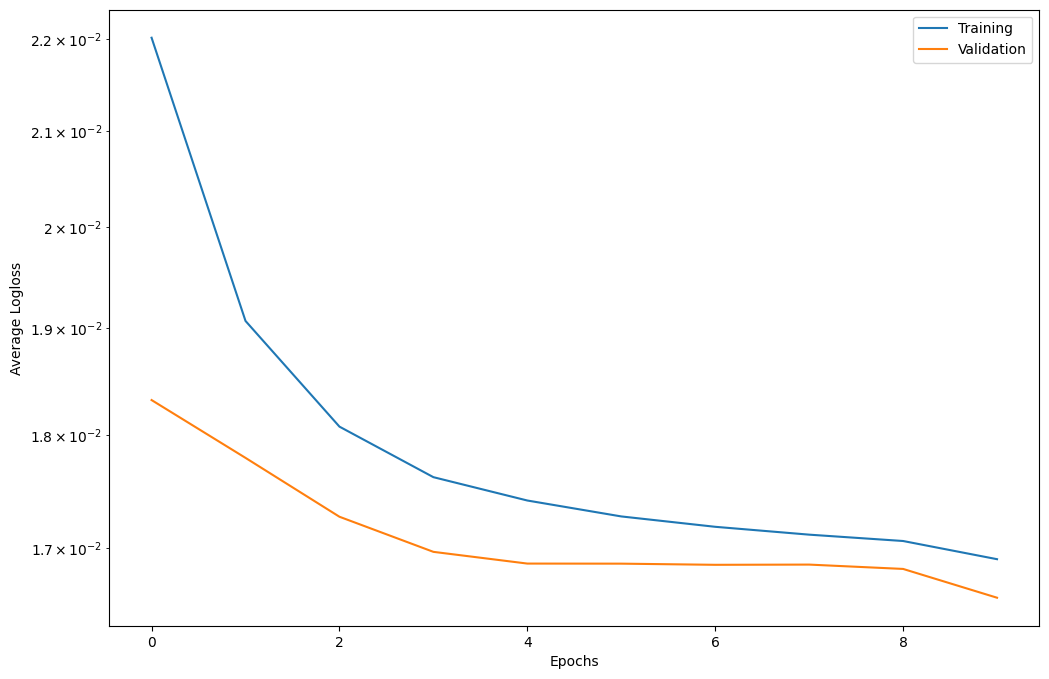

In [17]:
plt.figure(figsize=(12,8))

hist_trains = []
hist_lens = []
for i in range(n_folds * n_seeds):
    hist_train = (hists[i]).history['logloss']
    hist_trains.append(hist_train)
    hist_lens.append(len(hist_train))
hist_train = []
for i in range(min(hist_lens)):
    hist_train.append(np.mean([hist_trains[j][i] for j in range(n_folds * n_seeds)]))
plt.plot(hist_train)

hist_vals = []
hist_lens = []
for i in range(n_folds * n_seeds):
    hist_val = (hists[i]).history['val_logloss']
    hist_vals.append(hist_val)
    hist_lens.append(len(hist_val))
hist_val = []
for i in range(min(hist_lens)):
    hist_val.append(np.mean([hist_vals[j][i] for j in range(n_folds * n_seeds)]))
plt.plot(hist_val)

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [18]:
p_min = 0.0005
p_max = 0.9995

# Generate submission file, Clip Predictions

sub = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
sub.iloc[:,1:] = np.clip(y_pred,p_min,p_max)

# Save Submission
sub.to_csv('submission.csv', index=False)
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001238,0.001541,0.001878,0.014549,0.024520,0.005375,0.003344,0.006008,0.000658,...,0.000940,0.001590,0.002728,0.001748,0.001910,0.001041,0.001137,0.003272,0.001819,0.001894
1,id_001897cda,0.000917,0.001337,0.001599,0.006242,0.012195,0.004607,0.003962,0.008063,0.003435,...,0.000638,0.001221,0.003182,0.001943,0.008021,0.000800,0.011927,0.001151,0.003892,0.002273
2,id_002429b5b,0.000649,0.000548,0.001692,0.009996,0.009990,0.001943,0.002346,0.002192,0.000500,...,0.000851,0.000559,0.002819,0.004129,0.001583,0.000500,0.003615,0.001614,0.001585,0.001935
3,id_00276f245,0.001035,0.001107,0.001703,0.013794,0.019012,0.005082,0.004057,0.005183,0.000500,...,0.000693,0.000761,0.003498,0.009656,0.003275,0.000537,0.003275,0.001863,0.001656,0.002430
4,id_0027f1083,0.001639,0.001495,0.001675,0.015412,0.020145,0.004203,0.004959,0.003280,0.000775,...,0.000935,0.000739,0.004477,0.004263,0.001826,0.000746,0.003994,0.001892,0.001039,0.001926
